# Python Plotter Overlay

**Data path and step / timestamp**

Select the relative path for your data file. Also select the step (int) or timestamp (in seconds) you want to plot. You only need to select one (time or step).

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#Define base_path
base_path = Path.cwd()

#Medusa
filename_med = base_path / "Med103_0d42e13Wcm2_5ps.txt"
#MULTI
filename = base_path / "fort.11"

#Path error handling
if not filename.exists():
    print(f"Error: Could not find file at {filename}")

step = 16
time_stamp = None #ps

### Array Definition - MULTI###
i, pos, v, rho, te, ti, depo = [], [], [], [], [], [], []
data = [i, pos, v, rho, te, ti, depo]

### Array Definition - Medusa ###
pos_med, rho_med, Te_med, Ti_med = [], [], [], []
data_med = [pos_med, rho_med, Te_med, Ti_med]

Select the variables you want to plot for fortran. 
- 0 - Index
- 1 - Position (x)
- 2 - Velocity (v)
- 3 - Density (rho)
- 4- Electronic Temperature (te)
- 5 - Ionic Temperature (ti)
- 6 - Deposition (depo)

In [92]:
x = data[1]
y = data[3]

Select the variables you want to plot for Medusa
- 0 - Position (x)
- 1 - Density (rho)
- 2 - Electronic Temperature (Te)
- 3 - Ionic Temperature (Ti)

In [93]:
x_med = data_med[0]
y_med = data_med[1]

Medusa Data processing

In [94]:
with open(filename_med, "r", encoding="utf-8", errors="ignore") as f_med:
    for line in f_med:
        s = line.strip()
        s = s.split()
        try:
            data_string_buffer = [float(n) for n in s]
            if len(data_string_buffer) == len(data_med):
                    for i in range(len(data_med)):
                        data_med[i].append(data_string_buffer[i])
        except:
             continue
        
x_med = np.array(x_med)
y_med = np.array(y_med)

Data processing for fort.11 files.

In [95]:
#File opening and iteration loop
step_buffer = None
time_stamp_buffer = None
collect_status = False

with open(filename, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        s = line.strip()
        s = s.split()
        if not s: #Checks if line is blank
            continue
        if s[0] == "step=":
            if collect_status == True:
                break
            if step != None:
                step_buffer = float(s[1])
                if step == step_buffer:
                    time_stamp_buffer = float(s[3])
                    collect_status = True
                else:
                    collect_status = False
            elif time_stamp != None:
                time_stamp_buffer = float(s[3])
                if abs(time_stamp_buffer - time_stamp) <= 0.2E-12:
                      step_buffer = float(s[1])
                      collect_status = True
                else:
                    collect_status = False
        elif collect_status == True:
            try:
                data_string_buffer = [float(n) for n in s]
                if len(data_string_buffer) == len(data):
                    for i in range(len(data)):
                        data[i].append(data_string_buffer[i])
            except:
                continue

#Plot
x = np.array(x) * 1e4 #if x is position, we need to convert to um
y = np.array(y)

Overlayed plot

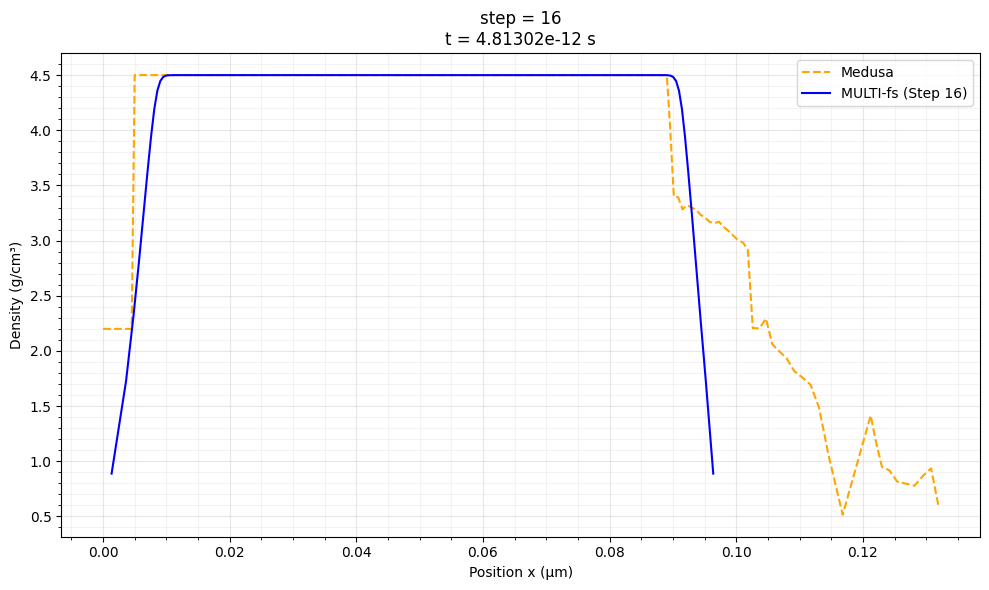

In [96]:
plt.figure(figsize=(10, 6)) # Make a nice-sized plot

# Plot Medusa data (dashed, orange)
plt.plot(x_med, y_med, label="Medusa", linestyle="--", color="orange")

#Mirror MULTI data:


# Plot MULTI data (solid, blue)
plt.plot(x+0.005, y, label=f"MULTI-fs (Step {int(step_buffer)})", color="blue")

# --- FIX: Your Y-label was wrong. You are plotting Density ---
plt.xlabel("Position x (µm)")
plt.ylabel("Density (g/cm³)") # Not Ti (eV)

if time_stamp_buffer is not None:
    title = "step = "+ str(int(step_buffer)) + f"\nt = " + f"{time_stamp_buffer}" + " s"
else:
    title = "Simulation Overlay"
    
plt.title(title)
plt.legend() # This now works because we added labels
plt.grid(True, alpha=0.3)
plt.minorticks_on()
plt.grid(True, which="minor", alpha=0.15)
plt.tight_layout()
plt.show()